In [2]:
import pandas as pd
data=pd.read_csv('worldometer_coronavirus_daily_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184787 entries, 0 to 184786
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     184787 non-null  object 
 1   country                  184787 non-null  object 
 2   cumulative_total_cases   184787 non-null  float64
 3   daily_new_cases          174329 non-null  float64
 4   active_cases             166747 non-null  float64
 5   cumulative_total_deaths  178227 non-null  float64
 6   daily_new_deaths         157850 non-null  float64
dtypes: float64(5), object(2)
memory usage: 9.9+ MB


In [3]:
# Count the number of entries for India
india_entries_count = data[data["country"] == "India"].shape[0]
print(f"Number of entries for India: {india_entries_count}")


Number of entries for India: 820


Trial 5 Complete [00h 04m 48s]
val_loss: 0.0031076391460373998

Best val_loss So Far: 0.0031076391460373998
Total elapsed time: 00h 41m 06s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Best Train RMSE: 911768.8609329158, Best Test RMSE: 808166.646061177
Best Train R²: 0.9949186748346599, Best Test R²: 0.9368035179058182


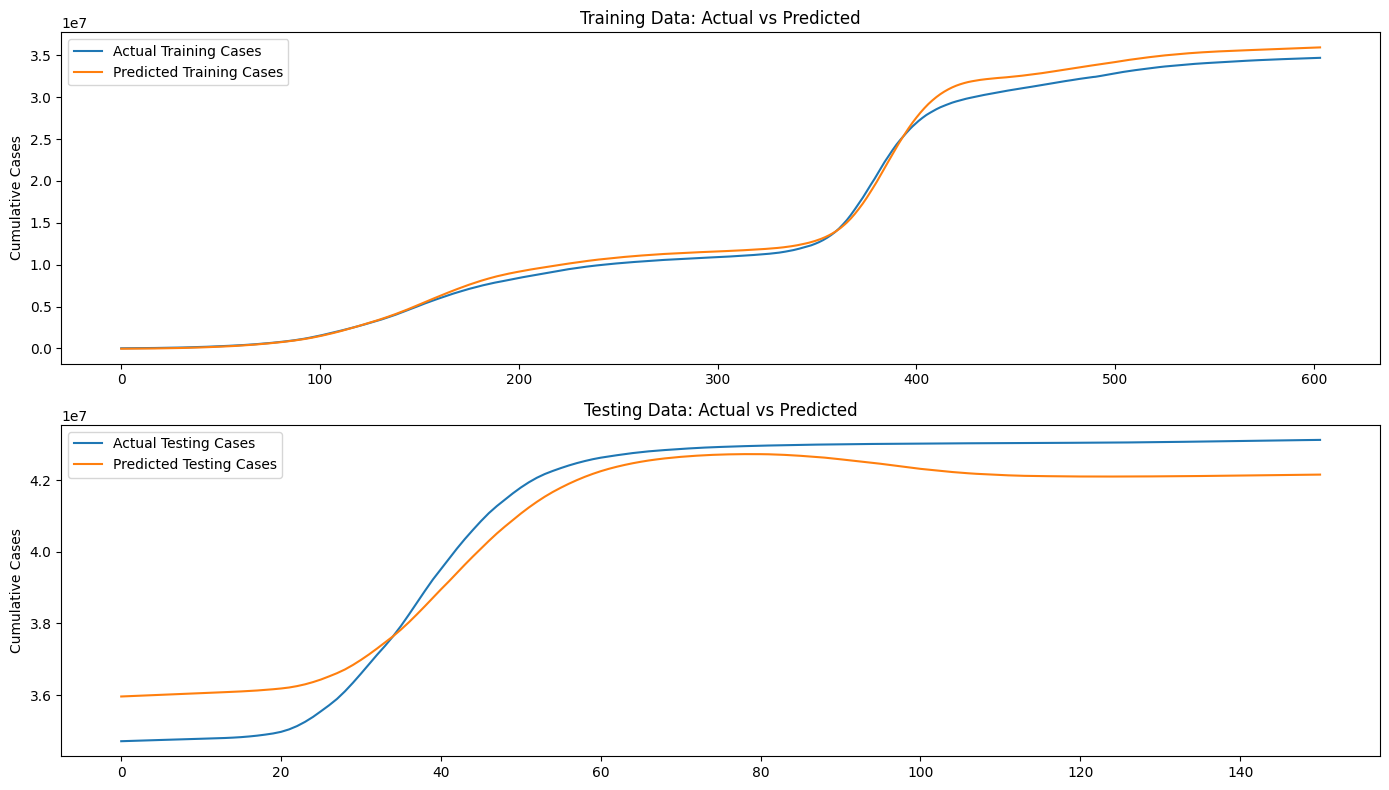

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch

# Step 1: Load and Preprocess Data

# Load the dataset
data = pd.read_csv('/kaggle/input/ittdataset/worldometer_coronavirus_daily_data.csv')

# Filter data for India
india_data = data[data['country'] == 'India'].copy()

# Convert 'date' to datetime
india_data['date'] = pd.to_datetime(india_data['date'])

# Sort the data by date
india_data.sort_values('date', inplace=True)

# Apply smoothing using exponential moving average
india_data['cumulative_total_cases'] = india_data['cumulative_total_cases'].ewm(span=3, adjust=False).mean()

# Create lag features (lag for the past 3 days)
for lag in range(1, 4):
    india_data[f'lag_{lag}'] = india_data['cumulative_total_cases'].shift(lag)

# Drop NaN values introduced by lagging
india_data.dropna(inplace=True)

# Select features and target variable
features = ['daily_new_cases', 'active_cases', 'cumulative_total_deaths', 'daily_new_deaths'] + [f'lag_{lag}' for lag in range(1, 4)]
target = 'cumulative_total_cases'

X = india_data[features]
y = india_data[target]

# Scale data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.array(y).reshape(-1, 1))


# Step 2: Create Sequences for Time Series Data

# Function to create sequences
def create_sequences(X, y, time_step):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

time_step = 60  # Set time step

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_step)

# Split data into training and testing sets (80/20 split)
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


# Step 3: Define the Model Using Keras Tuner

# Define a hypermodel for Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # First Bidirectional LSTM layer with tunable units and dropout
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), 
                                 return_sequences=True, kernel_regularizer=l2(0.01)),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    
    # Second Bidirectional LSTM layer with tunable units
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                                 return_sequences=False, kernel_regularizer=l2(0.01))))
    model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(units=1))

    # Compile model with tunable learning rate
    optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


# Step 4: Initialize Keras Tuner for Hyperparameter Search

# Initialize the Keras tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Number of different configurations to try
    executions_per_trial=2,  # Each trial will run twice
    directory='keras_tuner_dir',
    project_name='covid_case_forecasting'
)

# Search for best hyperparameters
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]


# Step 5: Train and Evaluate the Best Model

# Predict on training and testing data using the best model
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

# Inverse transform the predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
train_r2 = r2_score(y_train_actual, train_predictions)
test_r2 = r2_score(y_test_actual, test_predictions)

# Print results
print(f"Best Train RMSE: {train_rmse}, Best Test RMSE: {test_rmse}")
print(f"Best Train R²: {train_r2}, Best Test R²: {test_r2}")


# Step 6: Plot the Predictions

# Plot the actual vs predicted cumulative cases for both training and testing sets
plt.figure(figsize=(14, 8))

# Training Data Plot
plt.subplot(2, 1, 1)
plt.plot(y_train_actual, label='Actual Training Cases')
plt.plot(train_predictions, label='Predicted Training Cases')
plt.title('Training Data: Actual vs Predicted')
plt.ylabel('Cumulative Cases')
plt.legend()

# Testing Data Plot
plt.subplot(2, 1, 2)
plt.plot(y_test_actual, label='Actual Testing Cases')
plt.plot(test_predictions, label='Predicted Testing Cases')
plt.title('Testing Data: Actual vs Predicted')
plt.ylabel('Cumulative Cases')
plt.legend()

plt.tight_layout()
plt.show()
